# Install necessary dependencies

In [ ]:
# %%capture
# This cell will take time
%pip install unsloth
# Also get the latest nightly Unsloth!
%pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

In [ ]:
%pip install torch --upgrade
%pip install torchvision --upgrade


## Fine-tuning model
1. Setting up model parameters
2. Downloading the base model

In [1]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any--> !CAN BE ADJUSTED!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [2]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2024.11.7: Fast Llama patching. Transformers = 4.46.2.
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1+cu124. CUDA = 8.9. CUDA Toolkit = 12.4.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


# Load model and wrap with LoRA adapters

In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 64, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 32,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.11.7 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


# Competition dataset

In [4]:
# download and load competition dataset

from datasets import load_dataset
dataset = load_dataset("ad6398/nyu-dl-teach-maths-comp")
# print and see dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'is_correct', 'answer', 'solution'],
        num_rows: 1000000
    })
    test: Dataset({
        features: ['question', 'is_correct', 'answer', 'solution'],
        num_rows: 10000
    })
})

# Tokenization
- ### Adding *Solution* as new token
- ### Modifying the EOS_TOKEN (handling the None case)
- ### Tokenizing the dataset

In [5]:
import torch
from transformers import AutoTokenizer
from datasets import DatasetDict

#preprocess to tokenize the dataset

import re
from transformers import AutoTokenizer
from datasets import DatasetDict

EOS_TOKEN = tokenizer.eos_token if tokenizer.eos_token is not None else '<|endoftext|>' # Common choice for models similar to GPT

# Preprocessing prompt template
prompt = """You are a great mathematician and you are tasked with finding if an answer to a given maths question is correct or not. Your response should be 'True' if correct, otherwise 'False'. Below is Question and Answer.

### Question:
{}

### Answer:
{}

### Solution:
{}

### Output:
{}

"""
# Ensure EOS_TOKEN is properly set
# EOS_TOKEN = tokenizer.eos_token if tokenizer.eos_token is not None else "\n"  # Set a default end-of-sequence token if None

#tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  # Replace with your specific LLM tokenizer

def formatting_prompts_func(examples):
    # Extract each component from examples
    questions = examples["question"]
    answers = examples["answer"]
    solutions = examples["solution"]
    outputs = examples["is_correct"]
    texts = []

    # Iterate over each element
    for question, answer, solution, output_val in zip(questions, answers, solutions, outputs):
        # Convert each to string to ensure no TypeError, handle None values
        question_str = str(question) if question is not None else ""
        answer_str = str(answer) if answer is not None else ""
        solution_str = str(solution) if solution is not None else ""
        output_str = str(output_val) if output_val is not None else ""

        # Format the prompt using the predefined template and append the EOS token
        formatted_text = prompt.format(question_str, answer_str, solution_str, output_str) + EOS_TOKEN
        texts.append(formatted_text)

    return {"text": texts}



# Apply the formatting function as a preprocessing step using map
dataset = DatasetDict({
    'train': dataset['train'].map(formatting_prompts_func, batched=True),
    'test': dataset['test'].map(formatting_prompts_func, batched=True)
})


import torch

def trim_tokens_after_eos(input_ids, attention_mask, eos_token_id=128001):
    # Find the EOS token and trim both input_ids and attention_mask after it
    try:
        eos_index = input_ids.index(eos_token_id) + 1  # Include the EOS token itself
        trimmed_input_ids = input_ids[:eos_index]
        trimmed_attention_mask = attention_mask[:eos_index]
        return trimmed_input_ids, trimmed_attention_mask
    except ValueError:
        # If EOS token is not found, return the original sequences
        return input_ids, attention_mask

def tokenize_func(examples):
    # Tokenize without adding extra special tokens
    tokenized_inputs = tokenizer(
        examples["text"], 
        padding='max_length', 
        truncation=True, 
        max_length=512, 
        return_tensors='pt', 
        add_special_tokens=False
    )
    
    # Lists to store trimmed input_ids and attention masks
    trimmed_input_ids = []
    trimmed_attention_masks = []
    
    # Iterate over each sequence to apply trimming
    for seq, mask in zip(tokenized_inputs["input_ids"], tokenized_inputs["attention_mask"]):
        seq_list = seq.tolist()
        mask_list = mask.tolist()
        
        # Trim tokens and attention mask after EOS token
        trimmed_seq, trimmed_mask = trim_tokens_after_eos(seq_list, mask_list, eos_token_id=128001)
        
        # Append results to the lists
        trimmed_input_ids.append(trimmed_seq)
        trimmed_attention_masks.append(trimmed_mask)

    # Return the trimmed inputs and attention masks as separate fields
    return {
        "input_ids": trimmed_input_ids,
        "attention_masks": trimmed_attention_masks
    }

# Apply the tokenizer to the dataset splits
dataset = DatasetDict({
    'train': dataset['train'].map(tokenize_func, batched=True),
    'test': dataset['test'].map(tokenize_func, batched=True)
})

# Display the first processed row from the training set for verification
print(dataset['train'][0])


{'question': 'What is the radius of the circle inscribed in triangle $ABC$ if $AB = 22, AC=12,$ and $BC=14$? Express your answer in simplest radical form.', 'is_correct': True, 'answer': '3.16227766016838', 'solution': "The circle is inscribed in a triangle, and we know the sides of the triangle.\nTo use the inradius formula, we need to know the area of the triangle.\nWe can use Heron's formula to calculate the area.\n<llm-code>\nimport math\nfrom sympy import *\n\nAB, AC, BC = 22, 12, 14\n\n# Calculate the semiperimeter and area using Heron's formula\ns = (AB + AC + BC) / 2\nK = sqrt(s * (s - AB) * (s - AC) * (s - BC))\n\nprint(K)\n</llm-code>\n<llm-code-output>\n75.8946638440411\n</llm-code-output>\nLet's now use the formula for the radius of the inscribed circle.\n<llm-code>\nr = K / s\nprint(r)\n</llm-code>\n<llm-code-output>\n3.16227766016838\n</llm-code-output>\nThe answer is \\boxed{3.16227766016838}", 'text': "You are a great mathematician and you are tasked with finding if an 

# SFT and Hyperparameters

- ## Training Args
- ## SFTTrainer args

In [6]:
from datasets import DatasetDict
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

# Split the dataset into train and validation sets
split_dataset = dataset['train'].train_test_split(test_size=0.3, seed=3407)
train_dataset = split_dataset['train']
val_dataset = split_dataset['test']  # Validation set

# Training arguments
training_args = TrainingArguments(
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    warmup_steps=5,
    max_steps=10,  # Set higher for real training; keep lower for testing
    learning_rate=5e-4,
    fp16=not is_bfloat16_supported(),
    bf16=is_bfloat16_supported(),
    logging_steps=1,
    optim="adamw_8bit",
    weight_decay=0.0001,
    lr_scheduler_type="linear",
    seed=3407,
    output_dir="outputs",
    report_to="none",  # Disable reporting to third-party tools like WandB
)

# Training the model using SFTTrainer
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,  # Use the train split
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=4,
    packing=False,
    args=training_args,
)

# Train the model


max_steps is given, it will override any value given in num_train_epochs


In [12]:
# trainer.train() #0.026, 0.025, 0.023, 0.021, 0.0208, 0.0203, 0.0201, 0.0197, 0.0196, 0.0195, 0.0189, 0.0183, 0.0180, 0.0172, 0.0170, 0.0160, 0.0155

for i in range(10):
    print(trainer.train()) 


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 700,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 2
\        /    Total batch size = 8 | Total steps = 10
 "-____-"     Number of trainable parameters = 167,772,160


Step,Training Loss
1,5.031400
2,5.285900
3,3.955800
4,2.546100
5,2.192600
6,1.190600
7,1.624400
8,1.686500
9,1.724100
10,0.778000


TrainOutput(global_step=10, training_loss=2.6015373945236204, metrics={'train_runtime': 35.3598, 'train_samples_per_second': 2.262, 'train_steps_per_second': 0.283, 'total_flos': 1664484159946752.0, 'train_loss': 2.6015373945236204, 'epoch': 0.00011428571428571428})


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 700,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 2
\        /    Total batch size = 8 | Total steps = 10
 "-____-"     Number of trainable parameters = 167,772,160


Step,Training Loss
1,0.682100
2,0.761700
3,0.481100
4,0.472800
5,0.388100
6,0.267400
7,0.235400
8,0.369400
9,0.225000
10,0.233600


TrainOutput(global_step=10, training_loss=0.41167324036359787, metrics={'train_runtime': 34.7111, 'train_samples_per_second': 2.305, 'train_steps_per_second': 0.288, 'total_flos': 1570202061275136.0, 'train_loss': 0.41167324036359787, 'epoch': 0.00011428571428571428})


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 700,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 2
\        /    Total batch size = 8 | Total steps = 10
 "-____-"     Number of trainable parameters = 167,772,160


Step,Training Loss
1,0.196900
2,0.323300
3,0.144100
4,0.143300
5,0.141000
6,0.131900
7,0.176300
8,0.261400
9,0.184300
10,0.167000


TrainOutput(global_step=10, training_loss=0.1869490623474121, metrics={'train_runtime': 34.5131, 'train_samples_per_second': 2.318, 'train_steps_per_second': 0.29, 'total_flos': 1570202061275136.0, 'train_loss': 0.1869490623474121, 'epoch': 0.00011428571428571428})


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 700,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 2
\        /    Total batch size = 8 | Total steps = 10
 "-____-"     Number of trainable parameters = 167,772,160


Step,Training Loss
1,0.117000
2,0.184400
3,0.092900
4,0.086000
5,0.088100
6,0.119500
7,0.071700
8,0.134800
9,0.101000
10,0.091900


TrainOutput(global_step=10, training_loss=0.10872708559036255, metrics={'train_runtime': 34.9308, 'train_samples_per_second': 2.29, 'train_steps_per_second': 0.286, 'total_flos': 1570202061275136.0, 'train_loss': 0.10872708559036255, 'epoch': 0.00011428571428571428})


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 700,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 2
\        /    Total batch size = 8 | Total steps = 10
 "-____-"     Number of trainable parameters = 167,772,160


Step,Training Loss
1,0.071700
2,0.116800
3,0.057600
4,0.056600
5,0.048200
6,0.081600
7,0.044200
8,0.099500
9,0.067900
10,0.074600


TrainOutput(global_step=10, training_loss=0.07186593934893608, metrics={'train_runtime': 35.6906, 'train_samples_per_second': 2.241, 'train_steps_per_second': 0.28, 'total_flos': 1570202061275136.0, 'train_loss': 0.07186593934893608, 'epoch': 0.00011428571428571428})


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 700,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 2
\        /    Total batch size = 8 | Total steps = 10
 "-____-"     Number of trainable parameters = 167,772,160


Step,Training Loss
1,0.047300
2,0.097100
3,0.058400
4,0.037000
5,0.031900
6,0.038800
7,0.042300
8,0.062500
9,0.054800
10,0.049600


TrainOutput(global_step=10, training_loss=0.05197146870195866, metrics={'train_runtime': 35.389, 'train_samples_per_second': 2.261, 'train_steps_per_second': 0.283, 'total_flos': 1570202061275136.0, 'train_loss': 0.05197146870195866, 'epoch': 0.00011428571428571428})


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 700,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 2
\        /    Total batch size = 8 | Total steps = 10
 "-____-"     Number of trainable parameters = 167,772,160


Step,Training Loss
1,0.040800
2,0.082200
3,0.064700
4,0.031200
5,0.027700
6,0.022500
7,0.021000
8,0.045300
9,0.040900
10,0.033700


TrainOutput(global_step=10, training_loss=0.04101838879287243, metrics={'train_runtime': 35.4743, 'train_samples_per_second': 2.255, 'train_steps_per_second': 0.282, 'total_flos': 1570202061275136.0, 'train_loss': 0.04101838879287243, 'epoch': 0.00011428571428571428})


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 700,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 2
\        /    Total batch size = 8 | Total steps = 10
 "-____-"     Number of trainable parameters = 167,772,160


Step,Training Loss
1,0.036900
2,0.077100
3,0.024200
4,0.022200
5,0.021400
6,0.021700
7,0.020600
8,0.029100
9,0.035200
10,0.034800


TrainOutput(global_step=10, training_loss=0.03233228791505098, metrics={'train_runtime': 34.0277, 'train_samples_per_second': 2.351, 'train_steps_per_second': 0.294, 'total_flos': 1570202061275136.0, 'train_loss': 0.03233228791505098, 'epoch': 0.00011428571428571428})


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 700,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 2
\        /    Total batch size = 8 | Total steps = 10
 "-____-"     Number of trainable parameters = 167,772,160


Step,Training Loss
1,0.038600
2,0.053100
3,0.023600
4,0.021000
5,0.025200
6,0.020800
7,0.018200
8,0.026900
9,0.029700
10,0.031600


TrainOutput(global_step=10, training_loss=0.02887470945715904, metrics={'train_runtime': 34.2194, 'train_samples_per_second': 2.338, 'train_steps_per_second': 0.292, 'total_flos': 1570202061275136.0, 'train_loss': 0.02887470945715904, 'epoch': 0.00011428571428571428})


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 700,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 2
\        /    Total batch size = 8 | Total steps = 10
 "-____-"     Number of trainable parameters = 167,772,160


Step,Training Loss
1,0.027800
2,0.043200
3,0.026900
4,0.020900
5,0.014800
6,0.017400
7,0.014900
8,0.015600
9,0.021000
10,0.023700


TrainOutput(global_step=10, training_loss=0.022611537761986256, metrics={'train_runtime': 35.0441, 'train_samples_per_second': 2.283, 'train_steps_per_second': 0.285, 'total_flos': 1570202061275136.0, 'train_loss': 0.022611537761986256, 'epoch': 0.00011428571428571428})


# Inference (over a fixed random sample)

In [8]:
import torch
from tqdm import tqdm
import random

FastLanguageModel.for_inference(model)

def validate_model_simple(model, tokenizer, val_dataset, num_samples=5000, batch_size=16):
    # Randomly select 5000 samples from the validation dataset
    random.seed(3407)
    indices = random.sample(range(len(val_dataset)), num_samples)
    val_subset = val_dataset.select(indices)

    correct_predictions = 0
    total_predictions = len(val_subset)

    # Set the model to evaluation mode
    model.eval()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # Disable gradient calculations for faster inference
    with torch.no_grad():
        for i in tqdm(range(0, total_predictions, batch_size), desc="Validating"):
            batch_end = min(i + batch_size, total_predictions)
            batch = val_subset[i:batch_end]

            # Prepare input prompts
            input_prompts = [
                prompt.format(q, a, s, "") for q, a, s in zip(batch["question"], batch["answer"], batch["solution"])
            ]

            # Tokenize the prompts
            inputs = tokenizer(input_prompts, return_tensors="pt", padding=True, truncation=True).to(device)

            # Generate outputs
            outputs = model.generate(**inputs, max_new_tokens=5, use_cache=True)

            # Decode the responses
            responses = tokenizer.batch_decode(outputs, skip_special_tokens=True)

            # Check predictions
            correct_predictions += sum(
                ("True" in response) == true_label for response, true_label in zip(responses, batch["is_correct"])
            )

            # Free memory
            del inputs, outputs, responses
            torch.cuda.empty_cache()

    # Calculate and print accuracy
    accuracy = correct_predictions / total_predictions
    print(f"Validation Accuracy on {total_predictions} samples: {accuracy:.4f}")

# Usage
validate_model_simple(model, tokenizer, val_dataset, num_samples=1000, batch_size=16)


Validating: 100%|██████████| 63/63 [04:50<00:00,  4.62s/it]

Validation Accuracy on 1000 samples: 0.3880


# Inference (over a specific data point)

In [9]:
# Sample inference data point
test_dataset = dataset['test']


# Result on test dataset (batch inference)

In [11]:
import csv
import torch
from tqdm import tqdm
from unsloth import FastLanguageModel

# Enable faster inference with FastLanguageModel
FastLanguageModel.for_inference(model)

def optimized_batch_evaluate_full_dataset(model, tokenizer, test_dataset, batch_size=16, output_file="submission_full_new2.csv"):
    # Define start and end indices for batch processing
    start_index = 0
    end_index = len(test_dataset)

    # Open the CSV file to write the results
    with open(output_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["ID", "is_correct"])  # Write headers once

        # Use tqdm to track progress and process in batches
        for i in tqdm(range(start_index, end_index, batch_size), desc="Processing batches"):
            batch_end = min(i + batch_size, end_index)
            batch = test_dataset[i:batch_end]

            # Prepare input prompts for each batch
            input_prompts = [
                prompt.format(q, a, s, "")  # Format the prompt without the output placeholder
                for q, a, s in zip(batch['question'], batch['answer'], batch['solution'])
            ]

            # Tokenize the entire batch at once and move to GPU if available
            inputs = tokenizer(input_prompts, return_tensors="pt", padding=True, truncation=True).to("cuda" if torch.cuda.is_available() else "cpu")

            # Get input token length for slicing generated outputs
            input_token_len = inputs['input_ids'].shape[1]

            # Generate predictions in batch
            with torch.no_grad():
                outputs = model.generate(**inputs, max_new_tokens=5, use_cache=True)

            # Decode responses from the generated outputs
            responses = tokenizer.batch_decode([output[input_token_len:] for output in outputs], skip_special_tokens=True)

            # Determine if the response contains "True" or "False" and prepare predictions for CSV
            batch_predictions = [
                [i + idx, "True" if "True" in response else "False"]
                for idx, response in enumerate(responses)
            ]

            # Write batch predictions to CSV at once
            writer.writerows(batch_predictions)

            # Clear memory after each batch
            del inputs, outputs, responses, batch_predictions
            torch.cuda.empty_cache()

            # Print progress information for every batch
            print(f"{i + batch_size} rows processed")

    print(f"Submission file saved as {output_file}")

# Usage
optimized_batch_evaluate_full_dataset(model, tokenizer, test_dataset)


Processing batches:   0%|          | 1/625 [00:03<40:08,  3.86s/it]

16 rows processed


Processing batches:   0%|          | 2/625 [00:08<43:08,  4.15s/it]

32 rows processed


Processing batches:   0%|          | 3/625 [00:12<45:04,  4.35s/it]

48 rows processed


Processing batches:   1%|          | 4/625 [00:16<42:37,  4.12s/it]

64 rows processed


Processing batches:   1%|          | 5/625 [00:20<40:48,  3.95s/it]

80 rows processed


Processing batches:   1%|          | 6/625 [00:22<36:09,  3.50s/it]

96 rows processed


Processing batches:   1%|          | 7/625 [00:29<45:45,  4.44s/it]

112 rows processed


Processing batches:   1%|▏         | 8/625 [00:32<43:24,  4.22s/it]

128 rows processed


Processing batches:   1%|▏         | 9/625 [00:36<39:59,  3.90s/it]

144 rows processed


Processing batches:   2%|▏         | 10/625 [00:40<41:05,  4.01s/it]

160 rows processed


Processing batches:   2%|▏         | 11/625 [00:43<39:09,  3.83s/it]

176 rows processed


Processing batches:   2%|▏         | 12/625 [00:47<37:11,  3.64s/it]

192 rows processed


Processing batches:   2%|▏         | 13/625 [00:51<39:41,  3.89s/it]

208 rows processed


Processing batches:   2%|▏         | 14/625 [00:56<42:59,  4.22s/it]

224 rows processed


Processing batches:   2%|▏         | 15/625 [01:02<48:03,  4.73s/it]

240 rows processed


Processing batches:   3%|▎         | 16/625 [01:07<49:24,  4.87s/it]

256 rows processed


Processing batches:   3%|▎         | 17/625 [01:10<43:12,  4.26s/it]

272 rows processed


Processing batches:   3%|▎         | 18/625 [01:13<39:01,  3.86s/it]

288 rows processed


Processing batches:   3%|▎         | 19/625 [01:17<40:00,  3.96s/it]

304 rows processed


Processing batches:   3%|▎         | 20/625 [01:21<40:46,  4.04s/it]

320 rows processed


Processing batches:   3%|▎         | 21/625 [01:25<39:09,  3.89s/it]

336 rows processed


Processing batches:   4%|▎         | 22/625 [01:31<45:18,  4.51s/it]

352 rows processed


Processing batches:   4%|▎         | 23/625 [01:35<44:09,  4.40s/it]

368 rows processed


Processing batches:   4%|▍         | 24/625 [01:39<41:38,  4.16s/it]

384 rows processed


Processing batches:   4%|▍         | 25/625 [01:44<45:59,  4.60s/it]

400 rows processed


Processing batches:   4%|▍         | 26/625 [01:49<47:37,  4.77s/it]

416 rows processed


Processing batches:   4%|▍         | 27/625 [01:53<44:11,  4.43s/it]

432 rows processed


Processing batches:   4%|▍         | 28/625 [01:58<45:05,  4.53s/it]

448 rows processed


Processing batches:   5%|▍         | 29/625 [02:01<40:31,  4.08s/it]

464 rows processed


Processing batches:   5%|▍         | 30/625 [02:04<38:28,  3.88s/it]

480 rows processed


Processing batches:   5%|▍         | 31/625 [02:08<38:41,  3.91s/it]

496 rows processed


Processing batches:   5%|▌         | 32/625 [02:12<37:35,  3.80s/it]

512 rows processed


Processing batches:   5%|▌         | 33/625 [02:15<36:38,  3.71s/it]

528 rows processed


Processing batches:   5%|▌         | 34/625 [02:19<35:28,  3.60s/it]

544 rows processed


Processing batches:   6%|▌         | 35/625 [02:22<33:47,  3.44s/it]

560 rows processed


Processing batches:   6%|▌         | 36/625 [02:25<33:18,  3.39s/it]

576 rows processed


Processing batches:   6%|▌         | 37/625 [02:28<32:39,  3.33s/it]

592 rows processed


Processing batches:   6%|▌         | 38/625 [02:31<30:01,  3.07s/it]

608 rows processed


Processing batches:   6%|▌         | 39/625 [02:34<32:11,  3.30s/it]

624 rows processed


Processing batches:   6%|▋         | 40/625 [02:38<34:25,  3.53s/it]

640 rows processed


Processing batches:   7%|▋         | 41/625 [02:41<32:45,  3.37s/it]

656 rows processed


Processing batches:   7%|▋         | 42/625 [02:46<36:19,  3.74s/it]

672 rows processed


Processing batches:   7%|▋         | 43/625 [02:49<35:00,  3.61s/it]

688 rows processed


Processing batches:   7%|▋         | 44/625 [02:53<36:10,  3.74s/it]

704 rows processed


Processing batches:   7%|▋         | 45/625 [02:56<33:53,  3.51s/it]

720 rows processed


Processing batches:   7%|▋         | 46/625 [03:00<32:57,  3.41s/it]

736 rows processed


Processing batches:   8%|▊         | 47/625 [03:02<30:52,  3.20s/it]

752 rows processed


Processing batches:   8%|▊         | 48/625 [03:06<31:45,  3.30s/it]

768 rows processed


Processing batches:   8%|▊         | 49/625 [03:09<32:02,  3.34s/it]

784 rows processed


Processing batches:   8%|▊         | 50/625 [03:13<34:38,  3.61s/it]

800 rows processed


Processing batches:   8%|▊         | 51/625 [03:17<35:01,  3.66s/it]

816 rows processed


Processing batches:   8%|▊         | 52/625 [03:21<34:47,  3.64s/it]

832 rows processed


Processing batches:   8%|▊         | 53/625 [03:24<33:40,  3.53s/it]

848 rows processed


Processing batches:   9%|▊         | 54/625 [03:29<36:21,  3.82s/it]

864 rows processed


Processing batches:   9%|▉         | 55/625 [03:33<39:14,  4.13s/it]

880 rows processed


Processing batches:   9%|▉         | 56/625 [03:36<35:23,  3.73s/it]

896 rows processed


Processing batches:   9%|▉         | 57/625 [03:40<34:20,  3.63s/it]

912 rows processed


Processing batches:   9%|▉         | 58/625 [03:43<32:20,  3.42s/it]

928 rows processed


Processing batches:   9%|▉         | 59/625 [03:47<33:47,  3.58s/it]

944 rows processed


Processing batches:  10%|▉         | 60/625 [03:51<34:57,  3.71s/it]

960 rows processed


Processing batches:  10%|▉         | 61/625 [03:55<36:13,  3.85s/it]

976 rows processed


Processing batches:  10%|▉         | 62/625 [03:59<38:13,  4.07s/it]

992 rows processed


Processing batches:  10%|█         | 63/625 [04:03<37:55,  4.05s/it]

1008 rows processed


Processing batches:  10%|█         | 64/625 [04:07<38:07,  4.08s/it]

1024 rows processed


Processing batches:  10%|█         | 65/625 [04:11<37:10,  3.98s/it]

1040 rows processed


Processing batches:  11%|█         | 66/625 [04:16<39:54,  4.28s/it]

1056 rows processed


Processing batches:  11%|█         | 67/625 [04:23<47:30,  5.11s/it]

1072 rows processed


Processing batches:  11%|█         | 68/625 [04:26<41:32,  4.47s/it]

1088 rows processed


Processing batches:  11%|█         | 69/625 [04:31<42:11,  4.55s/it]

1104 rows processed


Processing batches:  11%|█         | 70/625 [04:36<42:21,  4.58s/it]

1120 rows processed


Processing batches:  11%|█▏        | 71/625 [04:40<41:34,  4.50s/it]

1136 rows processed


Processing batches:  12%|█▏        | 72/625 [04:43<37:49,  4.10s/it]

1152 rows processed


Processing batches:  12%|█▏        | 73/625 [04:47<37:44,  4.10s/it]

1168 rows processed


Processing batches:  12%|█▏        | 74/625 [04:50<35:20,  3.85s/it]

1184 rows processed


Processing batches:  12%|█▏        | 75/625 [04:53<32:47,  3.58s/it]

1200 rows processed


Processing batches:  12%|█▏        | 76/625 [04:56<29:54,  3.27s/it]

1216 rows processed


Processing batches:  12%|█▏        | 77/625 [05:00<31:29,  3.45s/it]

1232 rows processed


Processing batches:  12%|█▏        | 78/625 [05:04<32:40,  3.58s/it]

1248 rows processed


Processing batches:  13%|█▎        | 79/625 [05:07<31:33,  3.47s/it]

1264 rows processed


Processing batches:  13%|█▎        | 80/625 [05:16<45:38,  5.03s/it]

1280 rows processed


Processing batches:  13%|█▎        | 81/625 [05:20<43:36,  4.81s/it]

1296 rows processed


Processing batches:  13%|█▎        | 82/625 [05:24<40:31,  4.48s/it]

1312 rows processed


Processing batches:  13%|█▎        | 83/625 [05:28<41:16,  4.57s/it]

1328 rows processed


Processing batches:  13%|█▎        | 84/625 [05:32<39:53,  4.42s/it]

1344 rows processed


Processing batches:  14%|█▎        | 85/625 [05:39<45:12,  5.02s/it]

1360 rows processed


Processing batches:  14%|█▍        | 86/625 [05:43<41:53,  4.66s/it]

1376 rows processed


Processing batches:  14%|█▍        | 87/625 [05:46<39:01,  4.35s/it]

1392 rows processed


Processing batches:  14%|█▍        | 88/625 [05:52<42:16,  4.72s/it]

1408 rows processed


Processing batches:  14%|█▍        | 89/625 [05:56<41:26,  4.64s/it]

1424 rows processed


Processing batches:  14%|█▍        | 90/625 [06:00<38:59,  4.37s/it]

1440 rows processed


Processing batches:  15%|█▍        | 91/625 [06:05<39:45,  4.47s/it]

1456 rows processed


Processing batches:  15%|█▍        | 92/625 [06:09<38:00,  4.28s/it]

1472 rows processed


Processing batches:  15%|█▍        | 93/625 [06:12<36:41,  4.14s/it]

1488 rows processed


Processing batches:  15%|█▌        | 94/625 [06:15<32:05,  3.63s/it]

1504 rows processed


Processing batches:  15%|█▌        | 95/625 [06:20<37:09,  4.21s/it]

1520 rows processed


Processing batches:  15%|█▌        | 96/625 [06:24<35:00,  3.97s/it]

1536 rows processed


Processing batches:  16%|█▌        | 97/625 [06:28<34:52,  3.96s/it]

1552 rows processed


Processing batches:  16%|█▌        | 98/625 [06:31<34:06,  3.88s/it]

1568 rows processed


Processing batches:  16%|█▌        | 99/625 [06:39<42:28,  4.85s/it]

1584 rows processed


Processing batches:  16%|█▌        | 100/625 [06:46<48:52,  5.59s/it]

1600 rows processed


Processing batches:  16%|█▌        | 101/625 [06:52<49:27,  5.66s/it]

1616 rows processed


Processing batches:  16%|█▋        | 102/625 [06:55<43:33,  5.00s/it]

1632 rows processed


Processing batches:  16%|█▋        | 103/625 [06:59<41:15,  4.74s/it]

1648 rows processed


Processing batches:  17%|█▋        | 104/625 [07:04<41:54,  4.83s/it]

1664 rows processed


Processing batches:  17%|█▋        | 105/625 [07:08<39:58,  4.61s/it]

1680 rows processed


Processing batches:  17%|█▋        | 106/625 [07:12<37:00,  4.28s/it]

1696 rows processed


Processing batches:  17%|█▋        | 107/625 [07:15<33:58,  3.93s/it]

1712 rows processed


Processing batches:  17%|█▋        | 108/625 [07:18<31:34,  3.67s/it]

1728 rows processed


Processing batches:  17%|█▋        | 109/625 [07:21<30:01,  3.49s/it]

1744 rows processed


Processing batches:  18%|█▊        | 110/625 [07:25<31:08,  3.63s/it]

1760 rows processed


Processing batches:  18%|█▊        | 111/625 [07:30<33:14,  3.88s/it]

1776 rows processed


Processing batches:  18%|█▊        | 112/625 [07:33<31:24,  3.67s/it]

1792 rows processed


Processing batches:  18%|█▊        | 113/625 [07:37<32:00,  3.75s/it]

1808 rows processed


Processing batches:  18%|█▊        | 114/625 [07:40<30:32,  3.59s/it]

1824 rows processed


Processing batches:  18%|█▊        | 115/625 [07:44<31:38,  3.72s/it]

1840 rows processed


Processing batches:  19%|█▊        | 116/625 [07:49<33:34,  3.96s/it]

1856 rows processed


Processing batches:  19%|█▊        | 117/625 [07:52<31:06,  3.67s/it]

1872 rows processed


Processing batches:  19%|█▉        | 118/625 [07:55<31:02,  3.67s/it]

1888 rows processed


Processing batches:  19%|█▉        | 119/625 [08:00<32:37,  3.87s/it]

1904 rows processed


Processing batches:  19%|█▉        | 120/625 [08:03<32:18,  3.84s/it]

1920 rows processed


Processing batches:  19%|█▉        | 121/625 [08:08<33:56,  4.04s/it]

1936 rows processed


Processing batches:  20%|█▉        | 122/625 [08:11<31:21,  3.74s/it]

1952 rows processed


Processing batches:  20%|█▉        | 123/625 [08:14<29:52,  3.57s/it]

1968 rows processed


Processing batches:  20%|█▉        | 124/625 [08:20<35:16,  4.22s/it]

1984 rows processed


Processing batches:  20%|██        | 125/625 [08:24<34:45,  4.17s/it]

2000 rows processed


Processing batches:  20%|██        | 126/625 [08:28<33:56,  4.08s/it]

2016 rows processed


Processing batches:  20%|██        | 127/625 [08:32<33:26,  4.03s/it]

2032 rows processed


Processing batches:  20%|██        | 128/625 [08:34<29:14,  3.53s/it]

2048 rows processed


Processing batches:  21%|██        | 129/625 [08:38<30:08,  3.65s/it]

2064 rows processed


Processing batches:  21%|██        | 130/625 [08:42<31:50,  3.86s/it]

2080 rows processed


Processing batches:  21%|██        | 131/625 [08:48<35:31,  4.31s/it]

2096 rows processed


Processing batches:  21%|██        | 132/625 [08:53<39:06,  4.76s/it]

2112 rows processed


Processing batches:  21%|██▏       | 133/625 [08:57<36:36,  4.47s/it]

2128 rows processed


Processing batches:  21%|██▏       | 134/625 [09:01<35:11,  4.30s/it]

2144 rows processed


Processing batches:  22%|██▏       | 135/625 [09:04<32:23,  3.97s/it]

2160 rows processed


Processing batches:  22%|██▏       | 136/625 [09:08<32:01,  3.93s/it]

2176 rows processed


Processing batches:  22%|██▏       | 137/625 [09:12<32:53,  4.04s/it]

2192 rows processed


Processing batches:  22%|██▏       | 138/625 [09:18<35:27,  4.37s/it]

2208 rows processed


Processing batches:  22%|██▏       | 139/625 [09:22<35:28,  4.38s/it]

2224 rows processed


Processing batches:  22%|██▏       | 140/625 [09:26<33:46,  4.18s/it]

2240 rows processed


Processing batches:  23%|██▎       | 141/625 [09:29<31:29,  3.90s/it]

2256 rows processed


Processing batches:  23%|██▎       | 142/625 [09:32<30:19,  3.77s/it]

2272 rows processed


Processing batches:  23%|██▎       | 143/625 [09:36<28:45,  3.58s/it]

2288 rows processed


Processing batches:  23%|██▎       | 144/625 [09:39<27:53,  3.48s/it]

2304 rows processed


Processing batches:  23%|██▎       | 145/625 [09:43<29:44,  3.72s/it]

2320 rows processed


Processing batches:  23%|██▎       | 146/625 [09:52<41:26,  5.19s/it]

2336 rows processed


Processing batches:  24%|██▎       | 147/625 [09:54<34:53,  4.38s/it]

2352 rows processed


Processing batches:  24%|██▎       | 148/625 [09:58<33:25,  4.20s/it]

2368 rows processed


Processing batches:  24%|██▍       | 149/625 [10:01<30:13,  3.81s/it]

2384 rows processed


Processing batches:  24%|██▍       | 150/625 [10:07<36:16,  4.58s/it]

2400 rows processed


Processing batches:  24%|██▍       | 151/625 [10:11<34:59,  4.43s/it]

2416 rows processed


Processing batches:  24%|██▍       | 152/625 [10:16<34:27,  4.37s/it]

2432 rows processed


Processing batches:  24%|██▍       | 153/625 [10:22<38:23,  4.88s/it]

2448 rows processed


Processing batches:  25%|██▍       | 154/625 [10:26<37:39,  4.80s/it]

2464 rows processed


Processing batches:  25%|██▍       | 155/625 [10:32<40:45,  5.20s/it]

2480 rows processed


Processing batches:  25%|██▍       | 156/625 [10:37<39:57,  5.11s/it]

2496 rows processed


Processing batches:  25%|██▌       | 157/625 [10:43<41:17,  5.29s/it]

2512 rows processed


Processing batches:  25%|██▌       | 158/625 [10:47<38:21,  4.93s/it]

2528 rows processed


Processing batches:  25%|██▌       | 159/625 [10:51<35:51,  4.62s/it]

2544 rows processed


Processing batches:  26%|██▌       | 160/625 [10:55<35:01,  4.52s/it]

2560 rows processed


Processing batches:  26%|██▌       | 161/625 [10:59<32:42,  4.23s/it]

2576 rows processed


Processing batches:  26%|██▌       | 162/625 [11:04<34:49,  4.51s/it]

2592 rows processed


Processing batches:  26%|██▌       | 163/625 [11:09<35:39,  4.63s/it]

2608 rows processed


Processing batches:  26%|██▌       | 164/625 [11:15<38:26,  5.00s/it]

2624 rows processed


Processing batches:  26%|██▋       | 165/625 [11:19<35:55,  4.69s/it]

2640 rows processed


Processing batches:  27%|██▋       | 166/625 [11:23<35:37,  4.66s/it]

2656 rows processed


Processing batches:  27%|██▋       | 167/625 [11:28<35:36,  4.66s/it]

2672 rows processed


Processing batches:  27%|██▋       | 168/625 [11:32<33:37,  4.41s/it]

2688 rows processed


Processing batches:  27%|██▋       | 169/625 [11:36<33:49,  4.45s/it]

2704 rows processed


Processing batches:  27%|██▋       | 170/625 [11:39<30:39,  4.04s/it]

2720 rows processed


Processing batches:  27%|██▋       | 171/625 [11:42<26:53,  3.55s/it]

2736 rows processed


Processing batches:  28%|██▊       | 172/625 [11:45<24:53,  3.30s/it]

2752 rows processed


Processing batches:  28%|██▊       | 173/625 [11:49<27:46,  3.69s/it]

2768 rows processed


Processing batches:  28%|██▊       | 174/625 [11:53<27:02,  3.60s/it]

2784 rows processed


Processing batches:  28%|██▊       | 175/625 [11:56<26:02,  3.47s/it]

2800 rows processed


Processing batches:  28%|██▊       | 176/625 [12:00<27:17,  3.65s/it]

2816 rows processed


Processing batches:  28%|██▊       | 177/625 [12:04<28:15,  3.79s/it]

2832 rows processed


Processing batches:  28%|██▊       | 178/625 [12:08<29:47,  4.00s/it]

2848 rows processed


Processing batches:  29%|██▊       | 179/625 [12:13<30:13,  4.07s/it]

2864 rows processed


Processing batches:  29%|██▉       | 180/625 [12:17<29:49,  4.02s/it]

2880 rows processed


Processing batches:  29%|██▉       | 181/625 [12:20<28:53,  3.90s/it]

2896 rows processed


Processing batches:  29%|██▉       | 182/625 [12:24<29:41,  4.02s/it]

2912 rows processed


Processing batches:  29%|██▉       | 183/625 [12:30<31:58,  4.34s/it]

2928 rows processed


Processing batches:  29%|██▉       | 184/625 [12:35<33:32,  4.56s/it]

2944 rows processed


Processing batches:  30%|██▉       | 185/625 [12:38<31:23,  4.28s/it]

2960 rows processed


Processing batches:  30%|██▉       | 186/625 [12:42<30:09,  4.12s/it]

2976 rows processed


Processing batches:  30%|██▉       | 187/625 [12:47<32:37,  4.47s/it]

2992 rows processed


Processing batches:  30%|███       | 188/625 [12:50<29:42,  4.08s/it]

3008 rows processed


Processing batches:  30%|███       | 189/625 [12:55<30:19,  4.17s/it]

3024 rows processed


Processing batches:  30%|███       | 190/625 [12:59<29:49,  4.11s/it]

3040 rows processed


Processing batches:  31%|███       | 191/625 [13:07<39:12,  5.42s/it]

3056 rows processed


Processing batches:  31%|███       | 192/625 [13:11<35:52,  4.97s/it]

3072 rows processed


Processing batches:  31%|███       | 193/625 [13:16<35:05,  4.87s/it]

3088 rows processed


Processing batches:  31%|███       | 194/625 [13:21<34:56,  4.86s/it]

3104 rows processed


Processing batches:  31%|███       | 195/625 [13:24<31:19,  4.37s/it]

3120 rows processed


Processing batches:  31%|███▏      | 196/625 [13:27<28:28,  3.98s/it]

3136 rows processed


Processing batches:  32%|███▏      | 197/625 [13:32<30:28,  4.27s/it]

3152 rows processed


Processing batches:  32%|███▏      | 198/625 [13:34<26:47,  3.77s/it]

3168 rows processed


Processing batches:  32%|███▏      | 199/625 [13:40<30:22,  4.28s/it]

3184 rows processed


Processing batches:  32%|███▏      | 200/625 [13:44<30:27,  4.30s/it]

3200 rows processed


Processing batches:  32%|███▏      | 201/625 [13:48<28:57,  4.10s/it]

3216 rows processed


Processing batches:  32%|███▏      | 202/625 [13:52<29:13,  4.15s/it]

3232 rows processed


Processing batches:  32%|███▏      | 203/625 [13:56<28:28,  4.05s/it]

3248 rows processed


Processing batches:  33%|███▎      | 204/625 [14:03<34:55,  4.98s/it]

3264 rows processed


Processing batches:  33%|███▎      | 205/625 [14:10<38:45,  5.54s/it]

3280 rows processed


Processing batches:  33%|███▎      | 206/625 [14:13<33:41,  4.82s/it]

3296 rows processed


Processing batches:  33%|███▎      | 207/625 [14:17<31:36,  4.54s/it]

3312 rows processed


Processing batches:  33%|███▎      | 208/625 [14:25<38:19,  5.51s/it]

3328 rows processed


Processing batches:  33%|███▎      | 209/625 [14:28<33:21,  4.81s/it]

3344 rows processed


Processing batches:  34%|███▎      | 210/625 [14:33<33:10,  4.80s/it]

3360 rows processed


Processing batches:  34%|███▍      | 211/625 [14:36<30:16,  4.39s/it]

3376 rows processed


Processing batches:  34%|███▍      | 212/625 [14:42<33:09,  4.82s/it]

3392 rows processed


Processing batches:  34%|███▍      | 213/625 [14:45<29:32,  4.30s/it]

3408 rows processed


Processing batches:  34%|███▍      | 214/625 [14:49<28:39,  4.18s/it]

3424 rows processed


Processing batches:  34%|███▍      | 215/625 [14:53<28:08,  4.12s/it]

3440 rows processed


Processing batches:  35%|███▍      | 216/625 [14:57<27:16,  4.00s/it]

3456 rows processed


Processing batches:  35%|███▍      | 217/625 [15:00<25:29,  3.75s/it]

3472 rows processed


Processing batches:  35%|███▍      | 218/625 [15:06<30:05,  4.44s/it]

3488 rows processed


Processing batches:  35%|███▌      | 219/625 [15:10<28:36,  4.23s/it]

3504 rows processed


Processing batches:  35%|███▌      | 220/625 [15:14<29:26,  4.36s/it]

3520 rows processed


Processing batches:  35%|███▌      | 221/625 [15:18<27:38,  4.10s/it]

3536 rows processed


Processing batches:  36%|███▌      | 222/625 [15:27<37:05,  5.52s/it]

3552 rows processed


Processing batches:  36%|███▌      | 223/625 [15:30<33:23,  4.98s/it]

3568 rows processed


Processing batches:  36%|███▌      | 224/625 [15:34<30:44,  4.60s/it]

3584 rows processed


Processing batches:  36%|███▌      | 225/625 [15:40<32:41,  4.90s/it]

3600 rows processed


Processing batches:  36%|███▌      | 226/625 [15:46<34:39,  5.21s/it]

3616 rows processed


Processing batches:  36%|███▋      | 227/625 [15:51<35:20,  5.33s/it]

3632 rows processed


Processing batches:  36%|███▋      | 228/625 [15:54<30:50,  4.66s/it]

3648 rows processed


Processing batches:  37%|███▋      | 229/625 [15:57<26:36,  4.03s/it]

3664 rows processed


Processing batches:  37%|███▋      | 230/625 [16:03<31:21,  4.76s/it]

3680 rows processed


Processing batches:  37%|███▋      | 231/625 [16:08<31:12,  4.75s/it]

3696 rows processed


Processing batches:  37%|███▋      | 232/625 [16:11<27:59,  4.27s/it]

3712 rows processed


Processing batches:  37%|███▋      | 233/625 [16:14<25:09,  3.85s/it]

3728 rows processed


Processing batches:  37%|███▋      | 234/625 [16:18<24:59,  3.83s/it]

3744 rows processed


Processing batches:  38%|███▊      | 235/625 [16:22<24:46,  3.81s/it]

3760 rows processed


Processing batches:  38%|███▊      | 236/625 [16:25<24:23,  3.76s/it]

3776 rows processed


Processing batches:  38%|███▊      | 237/625 [16:30<25:58,  4.02s/it]

3792 rows processed


Processing batches:  38%|███▊      | 238/625 [16:33<23:41,  3.67s/it]

3808 rows processed


Processing batches:  38%|███▊      | 239/625 [16:37<23:49,  3.70s/it]

3824 rows processed


Processing batches:  38%|███▊      | 240/625 [16:40<23:45,  3.70s/it]

3840 rows processed


Processing batches:  39%|███▊      | 241/625 [16:44<24:34,  3.84s/it]

3856 rows processed


Processing batches:  39%|███▊      | 242/625 [16:48<24:05,  3.77s/it]

3872 rows processed


Processing batches:  39%|███▉      | 243/625 [16:51<22:32,  3.54s/it]

3888 rows processed


Processing batches:  39%|███▉      | 244/625 [16:55<22:48,  3.59s/it]

3904 rows processed


Processing batches:  39%|███▉      | 245/625 [16:59<24:17,  3.84s/it]

3920 rows processed


Processing batches:  39%|███▉      | 246/625 [17:03<24:05,  3.81s/it]

3936 rows processed


Processing batches:  40%|███▉      | 247/625 [17:06<22:23,  3.55s/it]

3952 rows processed


Processing batches:  40%|███▉      | 248/625 [17:10<23:00,  3.66s/it]

3968 rows processed


Processing batches:  40%|███▉      | 249/625 [17:15<26:32,  4.24s/it]

3984 rows processed


Processing batches:  40%|████      | 250/625 [17:23<33:05,  5.29s/it]

4000 rows processed


Processing batches:  40%|████      | 251/625 [17:26<28:44,  4.61s/it]

4016 rows processed


Processing batches:  40%|████      | 252/625 [17:29<25:38,  4.13s/it]

4032 rows processed


Processing batches:  40%|████      | 253/625 [17:33<24:20,  3.93s/it]

4048 rows processed


Processing batches:  41%|████      | 254/625 [17:37<25:41,  4.16s/it]

4064 rows processed


Processing batches:  41%|████      | 255/625 [17:41<24:59,  4.05s/it]

4080 rows processed


Processing batches:  41%|████      | 256/625 [17:44<23:00,  3.74s/it]

4096 rows processed


Processing batches:  41%|████      | 257/625 [17:49<25:02,  4.08s/it]

4112 rows processed


Processing batches:  41%|████▏     | 258/625 [17:53<24:40,  4.03s/it]

4128 rows processed


Processing batches:  41%|████▏     | 259/625 [17:57<24:13,  3.97s/it]

4144 rows processed


Processing batches:  42%|████▏     | 260/625 [18:01<24:05,  3.96s/it]

4160 rows processed


Processing batches:  42%|████▏     | 261/625 [18:04<22:58,  3.79s/it]

4176 rows processed


Processing batches:  42%|████▏     | 261/625 [18:08<25:18,  4.17s/it]


KeyboardInterrupt: 

# Loss curve (training loss V steps)

# Training loss curve (Training loss vs max_steps)

In [2]:
%pip install matplotlib
%pip install numpy

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/46/87/5f567fda78130a8394f9dcf3accb1b7b0c9baf0384307ef59032f5b1d17c/matplotlib-3.9.2-cp39-cp39-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/ec/22/19f5b948367ab5260fb41d842c7a78dae645603881ea6bc39738bcfcabf6/contourpy-1.3.0-cp39-cp39-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/ca/83/12c26ce25df9de2d247c31f27cddd1acd08078ad18631032db6ce946f01e/fonttools-4.55.0-cp39-cp39-macosx_10_9_universal2.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.5/164.5 kB 3.9 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency inform

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# losses are used directly from the training loss table
losses = [5.031400, 5.285900, 3.955800, 2.546100, 2.192600, 1.190600, 1.624400, 1.724100, 0.778000, 0.682100, 0.761700, 0.481100,
          0.472800, 0.388100, 0.267400, 0.235400, 0.369400, 0.225000, 0.233600, 0.196900, 0.323300, 0.144100, 0.143300, 0.131900,
          0.176300, 0.261400, 0.184300, 0.167000, 0.117000, 0.184400, 0.092900, 0.086000, 0.088100, 0.091900, 0.081600, 0.044200,
          0.099500, 0.067900, 0.074600, 0.047300, 0.058400, 0.037000, 0.031900, 0.049600, 0.064700, 0.031200, 0.027700, 0.021000,
          0.025200, 0.020800, 0.018200, 0.026900
        ]
steps = np.arange(1, len(losses) + 1)  # corresponding steps

Matplotlib is building the font cache; this may take a moment.


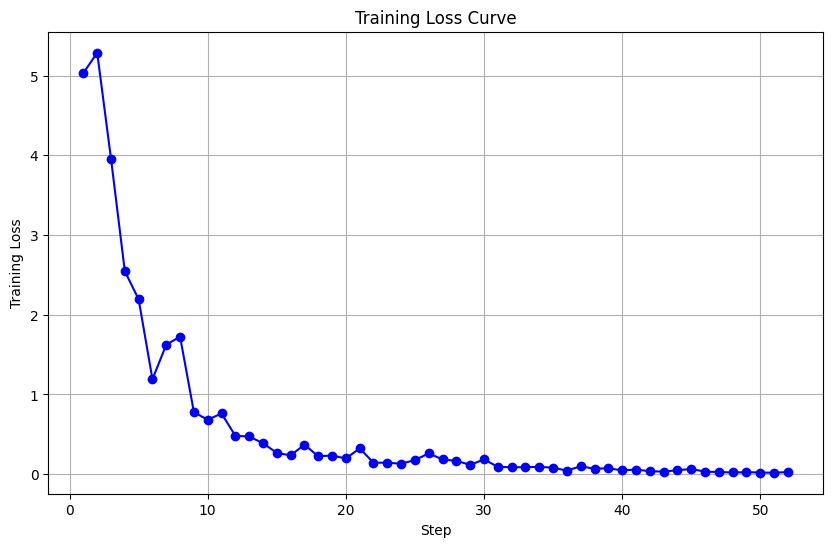

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(steps, losses, marker='o', linestyle='-', color='blue')
plt.xlabel('Step')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

## Observation

The training loss curve exhibits a sharp decline in the initial stages, indicating rapid learning and model adaptation. However, it plateaus after around 10 steps, suggesting that the model may have reached its capacity to learn from the training data. This could be due to overfitting (as we didn't find the same accuracy on the test data), and further tuning of hyperparameters or data augmentation could have improved the model's performance.